# Cross Validation

It is a type of regularization method (to give a more generalized & confident reporting on evaluation metric)

Reference-

https://scikit-learn.org/stable/modules/cross_validation.html

* Understand importance of cross validation
* How to perform cross validation using sklearn library
* Understand various parameters involved in cross validation

## Import Libraries

- In Scikit learn we have 2 functions to perform cross validation which is cross_val_score, cross_validate.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression



In [2]:
data = pd.read_csv('datasets/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Select Target and Features

In [3]:
X = data.drop('charges', axis=1)
y = data['charges']

In [4]:
X.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [5]:
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

In [6]:
X_ohe = pd.get_dummies(X)

In [7]:
X_ohe.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


## Use of drop_first=True valid for only binary columns.

X_ohe = pd.get_dummies(X)

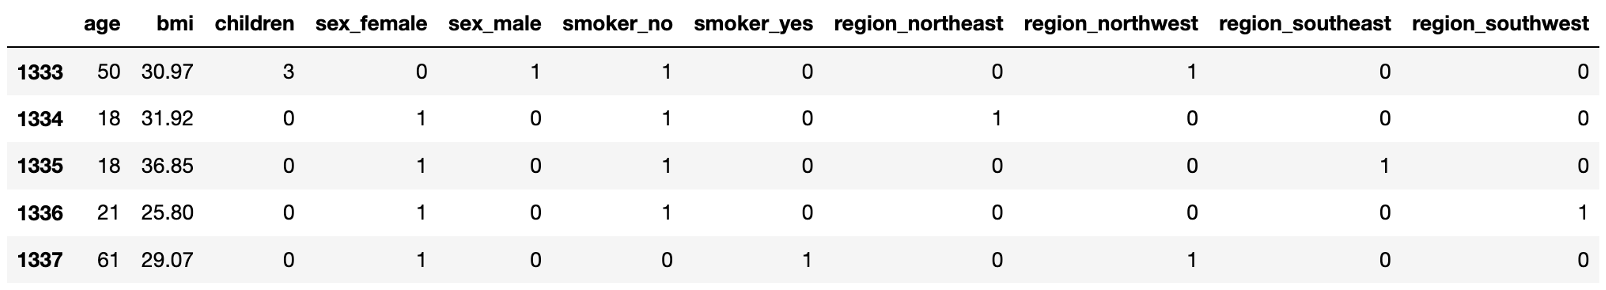

X_ohe = pd.get_dummies(X, drop_first=True)  

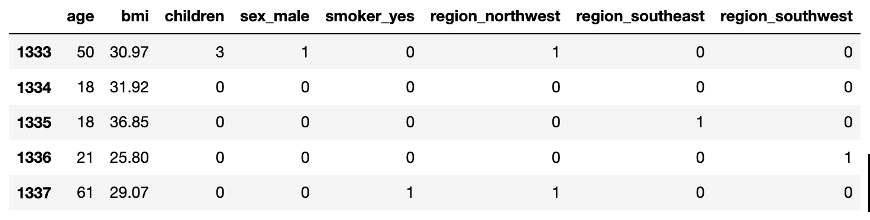

Conclusion - We want to do drop_first=true only for binary columns else information will be lost for eg in record 1334 we have no information for region (all are 0;s) because the information column is dropped.

## Train-Test Split

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X_ohe, y, test_size=.2, random_state=1)

In [9]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((1070, 11), (268, 11), (1070,), (268,))

## Model

In [10]:
# 1. Instantiate
dr = DecisionTreeRegressor(max_depth=5)

# 2. Fit
dr.fit(train_x, train_y)

# 3. Predict
ypred = dr.predict(test_x)    # ypred is on test_x (20% data)

# 4. Evaluate
print('RMSE: %.2f' % np.sqrt(mean_squared_error(test_y, ypred)))
print('R2 Score : %.2f' % r2_score(test_y, ypred))

RMSE: 4634.19
R2 Score : 0.86


Now if we change random seed, the split of train & test data will be different & hence performace of model will vary slightly. You cant have a reference state which will always give you optimal value, it is just a reference number. So how do we generalize? Because right now it is sensitive to the way u r picking training & testing samples. So for evaluation metric like R^2 along with parameter value we also specify what is avg value we can expect. So expected avg value of evaluation metric will be reported.

So instead of as reported above R2 Score : 0.86, we need to specify expected avg R2 Score by building various models with different training & testing samples.

## Manual running model 5 times with different train & test split as no random seed specified to provide a generalized (averaged) result on evaluation metric.

In [11]:
for i in range(5):
    
    train_x, test_x, train_y, test_y = train_test_split(X_ohe, y, test_size=.2)
    dr = DecisionTreeRegressor(max_depth=5).fit(train_x, train_y)
    ypred = dr.predict(test_x)
    print('R2 Score : %.2f' % r2_score(test_y, ypred))
    

R2 Score : 0.79
R2 Score : 0.86
R2 Score : 0.85
R2 Score : 0.84
R2 Score : 0.83


We can report the average of above scores.

# Cross Validation

In reality we manually doing splitting of data 5 times to get different datasets to report an average evaluation metric, instead we use Cross Validation technique for this. So these manual steps below will be repeated but this ***Cross Validation will be done on Training data itself (80% data of initial split).**



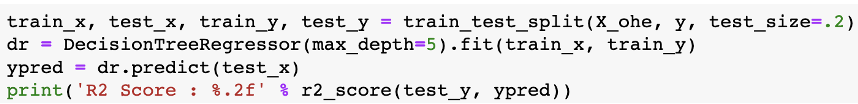

- Cross Validation will take your training data & divide into 5 folds (if 5 fold cross validation). So it will give validation/test score from fold 1 & if u want can get training score as well (by testing model on training data itself) by Fold 2 to 5 in case of Split1. 
- 5 models from 5 splits. So 5 corresponding scores to report an average value of performance metric.
- The final evaluation can still be done on Test data cz splits we r doing r on training data.

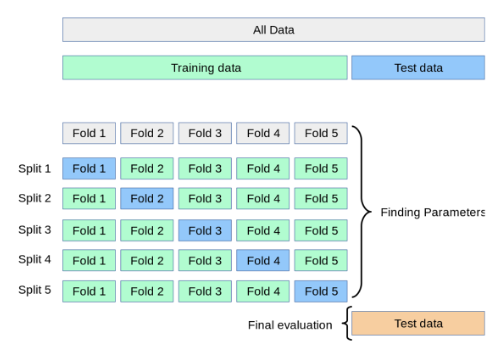

# Cross validation implementation in scikit learn using cross_val_score()

- Now when you build model you only instantiate it with default parameters. You do not fit using train_x, train_y instead u use cross_val_score & provide your instantiated model & training data to that cross_val_score function itself.

- Using cross_val_score with default R^square metric

In [12]:
dr1 = DecisionTreeRegressor(max_depth=5)
scores1 = cross_val_score(dr1, train_x, train_y, cv=5)
scores1

array([0.76842176, 0.86245902, 0.87623156, 0.80417242, 0.87741123])

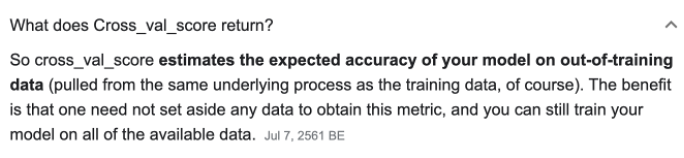

In case you set aside validation data for evaluating purpose then training data left would be lesser hence cv better because it internally splits from your training data itself.

- cross_val_score should return R2_score for Regression and Accuracy metric for classification problem by default. These metrics can be changed based on preference for e.g. to f1 score.
- Instead of reporting 1 r^square value we can report a range of r^square as you can expect in reality.

In [13]:
avg_score = scores1.mean()
sqr_std = scores1.std()*2

print('Expected R Square: %.2f (+/- %.2f)' %(avg_score, sqr_std))
print('Range for R Square: %.2f - %.2f' %(avg_score - sqr_std, avg_score + sqr_std))

Expected R Square: 0.84 (+/- 0.09)
Range for R Square: 0.75 - 0.93


## Final Evaluation on 20% Test data - cannot use dr1 to predict as not fitted error.

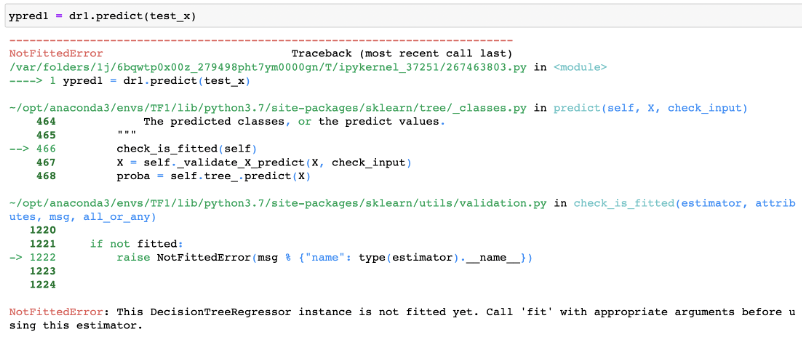

When we try to predict using dr1 model, we get not fitted error which means cross validation is just a regularization technique to ensure confidence on the results which will be reported. Actually we need to fit and predict on whole training data itself (80%) & test on (20%) data as per dataset split.

# Scorings available with CV

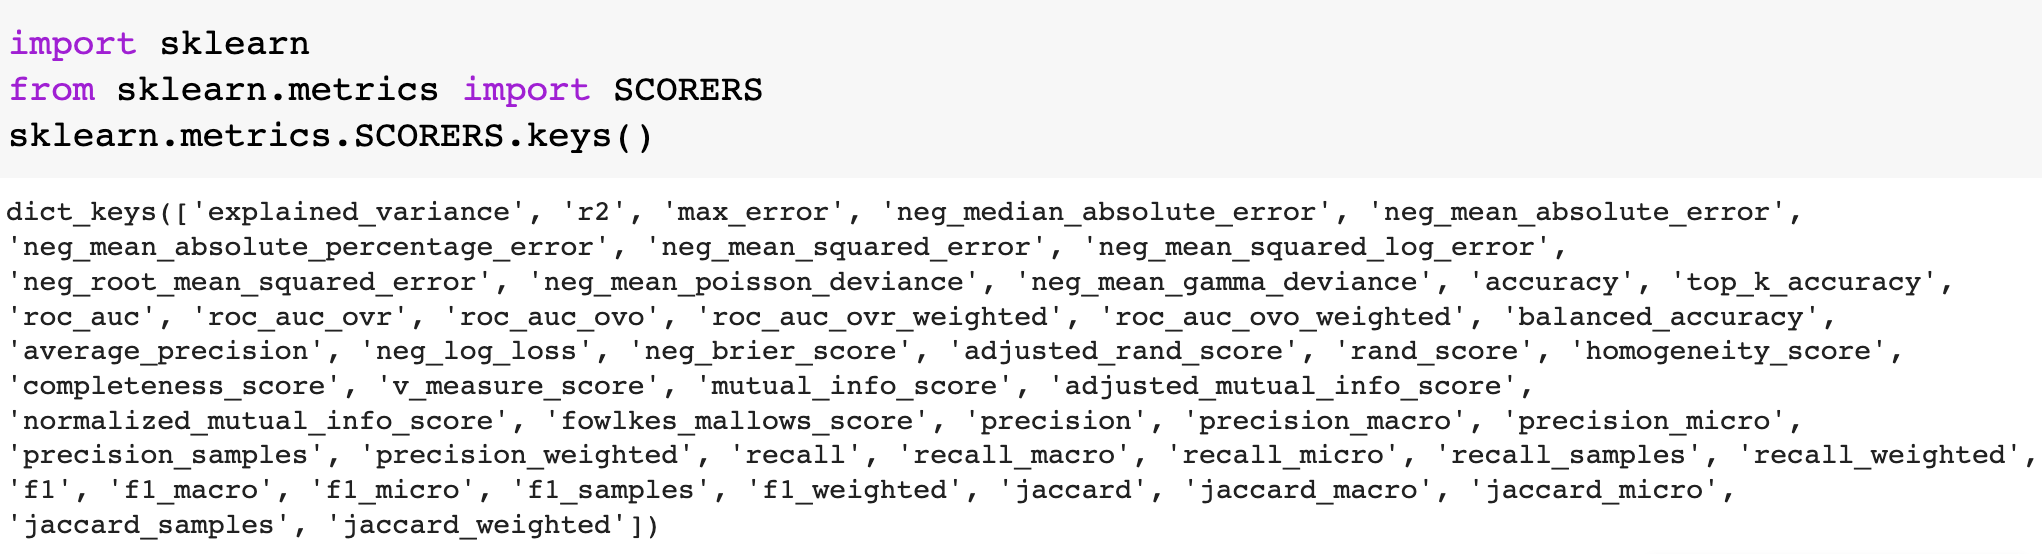

- Anything w.r.t error it adds a negative symbol before.neg_mean_squared_error, neg_mean_squared_log_error,neg_root_mean_squared_error. So that internally when performing hyperparameter tuning usually scoring mechanism should be as high as possible whereas when u look at errors it should be as low as possible. So all parameters related to error you will be getting -ve symbol in o/p, which can be ignored as below we do with neg_root_mean_squared_error.

- Using cross_val_score with metric neg_root_mean_squared_error

In [14]:
scores2 = cross_val_score(dr1, train_x, train_y, cv=5, scoring='neg_root_mean_squared_error')
scores2

array([-5670.81240037, -4873.9730302 , -4610.98306555, -4974.60409966,
       -3841.37338889])

## Cross_validate function

This function is similar to cross_val_score but apart from scores obtained in each split it also gives the time taken to calculate score in each split.

- fit_time
- score_time 
- test_scores

In [15]:
cv_results = cross_validate(dr1, train_x, train_y, cv=5, return_estimator=True)    # returns time it took to calc the scores
cv_results 

{'fit_time': array([0.00201702, 0.00149298, 0.00149083, 0.00146627, 0.00148201]),
 'score_time': array([0.00067377, 0.00063086, 0.00062013, 0.00060081, 0.00059915]),
 'estimator': [DecisionTreeRegressor(max_depth=5),
  DecisionTreeRegressor(max_depth=5),
  DecisionTreeRegressor(max_depth=5),
  DecisionTreeRegressor(max_depth=5),
  DecisionTreeRegressor(max_depth=5)],
 'test_score': array([0.7684855 , 0.86245902, 0.87623156, 0.80417242, 0.87741123])}

In [16]:
for fold_num, estimator in enumerate(cv_results['estimator']):
    print(f'Fold {fold_num+1} model: {estimator}')

Fold 1 model: DecisionTreeRegressor(max_depth=5)
Fold 2 model: DecisionTreeRegressor(max_depth=5)
Fold 3 model: DecisionTreeRegressor(max_depth=5)
Fold 4 model: DecisionTreeRegressor(max_depth=5)
Fold 5 model: DecisionTreeRegressor(max_depth=5)


## Final Evaluation on 20% Test data

## Predictions on unseen test data using Best Model out of the 5 models based on 5 splits of data

Now here Fold 3 model gave the best accuracy so we can use that model to make predictions on unseen data.

In [22]:
# Predict using the best estimator here 5th estimator i.e. index4
test_predictions = cv_results['estimator'][4].predict(test_x)

In [23]:
from sklearn.metrics import r2_score

r_squared = r2_score(test_y, test_predictions)
print(f"R-squared score: {r_squared}")


R-squared score: 0.827571129204127


# Display train scores also

### By default cross_validate will give test_score only i.e e.g. the score calculated on fold 1 in split 1. But it is possible to evaluate ur model on training samples also i.e. Fold 2 to Fold 4 which is used for building/training model. use return_train_score=True for that.

In [19]:
cv_results1 = cross_validate(dr1, train_x, train_y, cv=5, return_train_score=True)
cv_results1 

{'fit_time': array([0.00276875, 0.0017097 , 0.00148916, 0.00145721, 0.00149393]),
 'score_time': array([0.00107908, 0.00062895, 0.00062108, 0.00060081, 0.0007422 ]),
 'test_score': array([0.7684855 , 0.86245902, 0.87623156, 0.80417242, 0.87741123]),
 'train_score': array([0.89973436, 0.88383435, 0.88374776, 0.8924275 , 0.88065778])}

## Pass multiple scoring parameters in a list

In [20]:
cv_results2 = cross_validate(dr1, train_x, train_y, cv=5, return_train_score=True, 
                            scoring=['neg_root_mean_squared_error', 'r2'])
cv_results2   

{'fit_time': array([0.00255632, 0.00149488, 0.00147104, 0.00149488, 0.00178719]),
 'score_time': array([0.00081158, 0.00076818, 0.00072098, 0.00073409, 0.00093794]),
 'test_neg_root_mean_squared_error': array([-5670.03190203, -4873.9730302 , -4610.98306555, -4974.60409966,
        -3841.37338889]),
 'train_neg_root_mean_squared_error': array([-3860.79768874, -4035.38395564, -4038.07383996, -4041.40876042,
        -4266.90041705]),
 'test_r2': array([0.7684855 , 0.86245902, 0.87623156, 0.80417242, 0.87741123]),
 'train_r2': array([0.89973436, 0.88383435, 0.88374776, 0.8924275 , 0.88065778])}

You get a dictionary like output which can be changed to dataframe for better analysis.

In [21]:
cv_df = pd.DataFrame(cv_results2) # converting results into df
cv_df.head()

,fit_time,score_time,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
0,0.002556,0.000812,-5670.031902,-3860.797689,0.768485,0.899734
1,0.001495,0.000768,-4873.973030,-4035.383956,0.862459,0.883834
2,0.001471,0.000721,-4610.983066,-4038.073840,0.876232,0.883748
3,0.001495,0.000734,-4974.604100,-4041.408760,0.804172,0.892427
4,0.001787,0.000938,-3841.373389,-4266.900417,0.877411,0.880658
